# Introduction and objective of the analysis
## Analysis Plan:

### Data Preparation
1. **Training Period:** Segment the 10-day training period into three bins: early (Days 1-3), middle (Days 4-7), and late (Days 8-10), based on the hypothesis that mice exhibit distinct learning phases.
2. **Subject Filtering:** Exclude that one dumb mouse
3. **Binning Rationale:** Justify the division into 3, 4, 3-day chunks, ideally based on literature or observed patterns indicating distinct phases of learning or behavioral adaptation.

### Prediction Strategy Encoding
- **Elemental Strategy:** Define as responses to individual cues (A, B, C). Encode as binary variables indicating the presence or absence of each cue.???
- **Combinatorial Strategy:** Define as responses to pairs of cues presented together (A&B, A&C, B&C). Encode as binary variables for each possible pair.???
- **Structural Strategy:** Define as responses to sequences of cues indicating a relationship (A→B, B→C, C→A). Encode as binary variables for each sequence.???

### Analysis Logic per Chunk
1. **Outcome Variable (Y):** Use the average number of licks per session as a quantitative measure of the mouse's response. This provides a direct metric for assessing engagement or interest.
2. **Regression Model Inputs:** 
   - For the **Elemental** approach, use binary variables indicating the presence of individual cues (A, B, C) as predictors.
   - For the **Combinatorial** approach, use binary variables representing combinations of cues (A&B, A&C, B&C) as predictors.
   - For the **Structural** approach, use binary variables for cue sequences (A→B, B→C, C→A) as predictors.
3. **Model Specification:** GLM?? 

### Comparative Analysis Across Time Bins
1. **Model Application:** Apply the specified regression models to each time bin to assess how well each prediction strategy predicts licking behavior.
2. **Hypothesis Testing:** Test the hypothesis that the effectiveness of prediction strategies evolves over time, with the expectation that:
   - The **Elemental** strategy will be most predictive in the early bin.
   - The **Combinatorial** strategy will gain predictive power in the middle bin.
   - The **Structural** strategy will be most effective in the late bin.

## skeleton idea
### Data 
1. Mose mouse are trained up to 10 days..
2. Drop the stupid mouse
3. Bin teh 10 days in to 3,4,3 chunks

### Encoding the different prediction strategy
- Elemental
- Combinatorial
- Structural

### Analysis logic in each chunk 
1. Check whether the mouse licked in each session (take the average of the lick_data column, so it should correlate to how many licks were done or no lick etc
2. This lick_data can be regarded as the Y for my regression
3. the input for the regression will be "A or B or C" (Elemental), or "AandB, AandC, BandC" (combinatorial), and "A->B, B->C, C->A, etc" (structural)

### Overall approach
1. Applying the three prediction regression models to each time bin and see how good they are at predicting the lick_data based on the strategy
2. Ideally, we hope to see that the elemntal appraoch will be highest for the first time bin, followed by combinatorial approach for second time bin and finally the structural appraoch for the last time bin.





NEW goal: (REMOVING CORRELATION between predictors)
- Run the regression just for each strategy and the ncompare the R score --> single precitor variance
- Slowlying removing predictors and looking how much the R^2 changes --> looking at the unique varaince (what varaince these predictors exclusively give) 
-   So in last stage without sturtcural teh R^2 will be very low.
- This removes correlations between predictors
goal is to show the unique varince for sturctual is higher than the other strageties esp in last stage 
- 05/03/2024
- implement the elemental but within it look into recency and primacy effect

FINALLY 19/03/2024
- We only take out each type prediction and see how the remianinb two works
- DONE (22/03/2024)


# Necessary imports and environment setup

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn import linear_model


# Other
import re


# Data loading and preliminary checks

In [2]:
data = pd.read_csv('/Users/chenx/Desktop/MacAskill Lab/Data/data_from_svenja/AM_April22_learning.csv',index_col=0)

In [3]:
#lick_data are strings atm --> turn them in to list of floats

#directly extract floating-point numbers from the lick_data strings
def extract_floats(lick_data_str):
    # Extract floating-point numbers using regex
    numbers = re.findall(r'\d+\.\d+', lick_data_str)
    # Convert extracted strings to floats
    float_numbers = [float(num) for num in numbers]
    return float_numbers

# Apply the function to extract floats from the 'lick_data' column
data['lick_data'] = data['lick_data'].apply(extract_floats)

# Now, calculate the average of these floats for each trial and create a new column
data['lick_data_avg'] = data['lick_data'].apply(lambda x: sum(x) / len(x) if x else 0)

# Display the first few rows to verify the extracted floats and calculated averages
data[['lick_data', 'lick_data_avg']].head()


,lick_data,lick_data_avg
0,"[0.002563, 0.001273, 0.002563, 0.002563, 0.002...",0.002348
1,"[0.002563, 0.002563, 0.002563, 0.002563, 0.002...",0.002563
2,"[0.002563, 0.002563, 0.002563, 0.002563, 0.002...",0.002563
3,"[0.002563, 0.001273, 0.002563, 0.002563, 0.001...",0.002133
4,"[0.001273, 0.002563, 0.002563, 0.002563, 0.002...",0.002348


In [4]:
# dropping mouse ID sn_70
data = data[data['mouse'] != 'sn_70']
#checking
'sn_70' in data['mouse'].unique()

False

# Data cleaning and preprocessing

In [5]:
def make_matrix(task_data, subject, stage):
    # Map stage to days
    stage_days = {
        1: [1, 2, 3],
        2: [4, 5, 6],
        3: [7,8, 9, 10]
    }

    stage_days = {
        1: [1, 2],
        2: [3, 4],
        3: [5, 6],
        4:[7,8],
        5:[9,10]
    }

    # Filter data for the specific mouse and stage
    GLM_data = task_data[(task_data.mouse == subject) & (task_data.day.isin(stage_days[stage]))].reset_index(drop=True)

    # Initialize GLM_matrix with specified columns including 'day'
    columns = ['lick', 'A', 'B', 'C', 'AandB', 'AandC', 'CandB', 'AB', 'BA', 'AC', 'CA', 'BC', 'CB', 'previous_reward', 'previous_choice', 'day']
    GLM_matrix = pd.DataFrame(0, index=np.arange(len(GLM_data)), columns=columns)
    GLM_matrix['day'] = GLM_data['day']  # Populate 'day' column from filtered data

    # Initialize variables for previous trial's reward and choice
    reward, choice = 0, 0

    # Define the mappings for each trial type
    trial_type_mapping = {
        'a->b': [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        'b->a': [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        'a->c': [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        'c->a': [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        'b->c': [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        'c->b': [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
    }

    # Process each trial
    for index, row in GLM_data.iterrows():
        trial_encoding = trial_type_mapping.get(row['trial_type'], [0]*12)
        GLM_matrix.loc[index, 'A':'CB'] = trial_encoding

        GLM_matrix.loc[index, 'previous_reward'] = reward
        GLM_matrix.loc[index, 'previous_choice'] = choice

        lick_value = 1 if row['hit'] > 0 or row['false_positive'] > 0 else 0
        GLM_matrix.loc[index, 'lick'] = lick_value

        # Update reward and choice for the next trial
        reward = 1 if row['hit'] > 0 else 0
        choice = 1 if lick_value == 1 else -1

    return GLM_matrix

# Assuming your data is in a DataFrame named `task_data`
unique_mice = data['mouse'].unique()

combined_GLM_matrix = pd.DataFrame()

for mouse in unique_mice:
    for stage in [1, 2, 3]:
        mouse_stage_GLM_matrix = make_matrix(data, mouse, stage)
        mouse_stage_GLM_matrix['mouse'] = mouse  # Redundant, just to emphasize
        mouse_stage_GLM_matrix['stage'] = stage
        combined_GLM_matrix = pd.concat([combined_GLM_matrix, mouse_stage_GLM_matrix], ignore_index=True)

print(combined_GLM_matrix.shape)


(5413, 18)


# Analysis

## Training the regression model regardless of the stages

In [6]:
def scikit_log_reg_est(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Initialize and fit the Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000)  # Increasing max_iter to ensure convergence
    log_reg.fit(X_train, y_train)

    # Make predictions
    y_train_pred = log_reg.predict(X_train)
    y_test_pred = log_reg.predict(X_test)

    # Calculate accuracy for training and testing sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Optionally, calculate AUC-ROC score for the testing set
    # Note: roc_auc_score requires probability scores of the positive class, not the binary predictions.
    y_test_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    test_auc_roc = roc_auc_score(y_test, y_test_prob)

    return log_reg, train_accuracy, test_accuracy, test_auc_roc

# Assuming X and y are already defined as per your dataset
X = combined_GLM_matrix.drop(columns=['lick', 'mouse', 'stage', 'day'])  # predictors
y = combined_GLM_matrix['lick']  # binary target

# Call the logistic regression estimation function
log_reg_model, train_accuracy, test_accuracy, test_auc_roc = scikit_log_reg_est(X, y)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC-ROC: {test_auc_roc}")


Training Accuracy: 0.6696230598669624
Test Accuracy: 0.7008862629246676
Test AUC-ROC: 0.7785916140904311


In [7]:
# Extract the coefficients of the logistic regression model
coefficients = log_reg_model.coef_[0]  # Coef_ returns an array of shape (1, n_features) for binary classification

# Create a DataFrame to display predictor names and their corresponding coefficients
import pandas as pd

# Assuming 'X' is your predictors DataFrame from before, ensuring column names match
predictor_names = X.columns
coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients to see the most influential predictors
coef_df_sorted = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df_sorted)


          Predictor  Coefficient
9                CA     0.857497
13  previous_choice     0.791008
7                BA    -0.772353
6                AB     0.751996
8                AC    -0.684945
11               CB    -0.604392
10               BC     0.527374
12  previous_reward    -0.275206
4             AandC     0.172552
0                 A     0.152194
1                 B    -0.097376
2                 C     0.095534
5             CandB    -0.077018
3             AandB    -0.020358


## Training the regression model across the stages

In [8]:
def run_logistic_regression_for_stage(data, stage_id):
    # Filter data for the current stage
    stage_data = data[data['stage'] == stage_id]

    # Prepare predictors (X) and target variable (y)
    X = stage_data.drop(columns=['lick', 'mouse', 'stage', 'day'])
    y = stage_data['lick']

    # Convert X to a format suitable for logistic regression
    X_formatted = np.array([X[col].tolist() for col in X]).T

    # Define the parameter range and grid
    param_range = np.arange(0.01, 10.1, 0.1)
    param_grid = [{'C': param_range}]

    # Initialize and run GridSearchCV to find the best regularization strength
    gs = GridSearchCV(estimator=linear_model.LogisticRegression(penalty='l2', solver='saga', fit_intercept=False, max_iter=10000),
                      param_grid=param_grid, scoring='roc_auc', cv=5)
    gs = gs.fit(X_formatted, y.tolist())

    # Initialize and fit Logistic Regression model with the best parameter
    log_reg = linear_model.LogisticRegression(C=gs.best_params_['C'], penalty='l2', solver='saga', fit_intercept=False, max_iter=10000)
    log_reg.fit(X_formatted, y.tolist())

    # Score the model
    score = log_reg.score(X_formatted, y.tolist())

    # Extract coefficients
    coefficients = dict(zip(X.columns, log_reg.coef_[0]))

    # Evaluate
    test_auc_roc = gs.best_score_  # Using the best AUC-ROC score from GridSearchCV as a proxy

    return coefficients, score, test_auc_roc

# Initialize an empty DataFrame to store coefficients
coefficients_df = pd.DataFrame()

# Assume combined_GLM_matrix is your dataset
# Run logistic regression for each stage and save coefficients
for stage_id in [1, 2, 3]:
    coefficients, test_accuracy, test_auc_roc = run_logistic_regression_for_stage(combined_GLM_matrix, stage_id)
    print(f"Stage {stage_id} - Test Accuracy: {test_accuracy}, Test AUC-ROC: {test_auc_roc}")

    # Convert coefficients to a DataFrame, transpose it, and rename the column to the current stage
    stage_coeffs_df = pd.DataFrame(coefficients, index=[f'Stage {stage_id}']).transpose()

    # Concatenate the transposed DataFrame with the initialized DataFrame
    coefficients_df = pd.concat([coefficients_df, stage_coeffs_df], axis=1)

# After loop, rename columns to reflect stages more clearly
coefficients_df.columns = ['Stage 1', 'Stage 2', 'Stage 3']

Stage 1 - Test Accuracy: 0.7182190978324546, Test AUC-ROC: 0.742027272815003
Stage 2 - Test Accuracy: 0.68019747668678, Test AUC-ROC: 0.7425147670737223
Stage 3 - Test Accuracy: 0.7233138608603292, Test AUC-ROC: 0.7844266290947521


## Recolor for better visualization

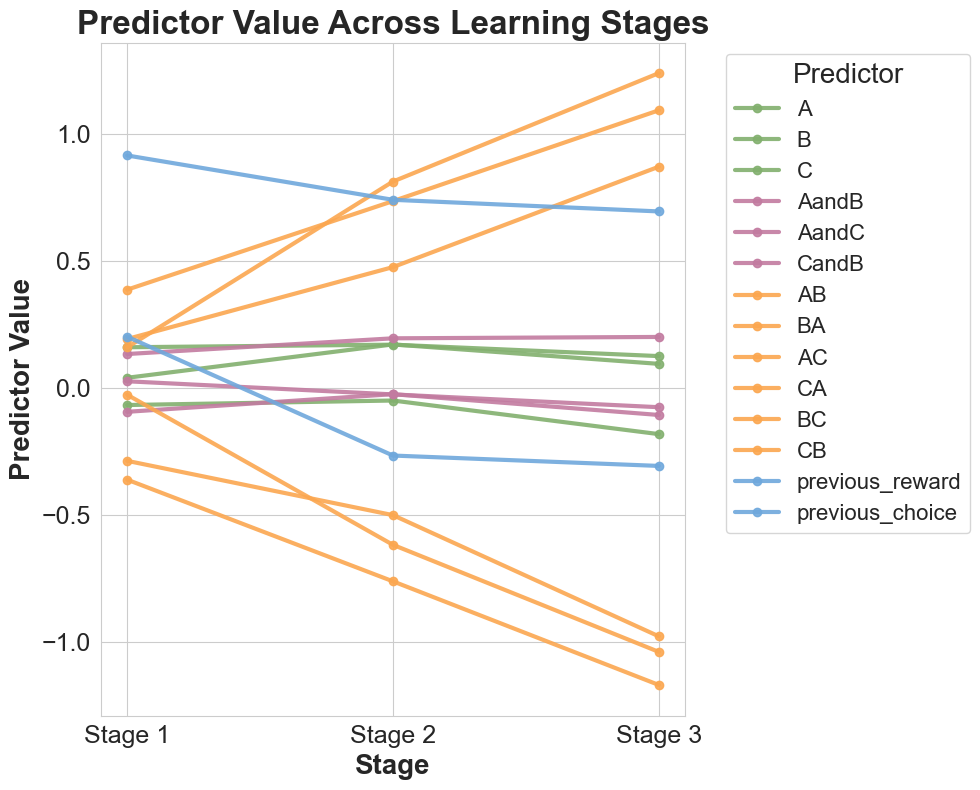

In [9]:
# Plot setup
plt.figure(figsize=(10, 8))

# Define colors for specific coefficients
colors = {
    'A': '#82b06e',  # Elemental green color
    'B': '#82b06e',
    'C': '#82b06e',
    'AandB': '#c27ba0',  # Configural background dark pink
    'AandC': '#c27ba0',
    'CandB': '#c27ba0',
    'AB': '#fba750',
    'BA': '#fba750',# Structural peach orange color
    'BC': '#fba750',
    'CB': '#fba750',
    'CA': '#fba750',
    'AC': '#fba750',
    'previous_reward': '#6fa8dc',
    'previous_choice': '#6fa8dc',
}


default_color = 'orange'  # Color for other coefficients

# Iterate through each row in the coefficients DataFrame to plot
for row in coefficients_df.iterrows():
    coef_name = row[0]  # Coefficient name
    coef_values = row[1]  # Coefficient values across stages
    # Determine the color based on coefficient name
    color = colors.get(coef_name, default_color)
    # Plot line with determined color
    plt.plot(coefficients_df.columns, coef_values, marker='o', label=coef_name, color=color,linewidth=3, alpha=0.9)

# Enhancing the Plot
plt.title('Predictor Value Across Learning Stages', fontweight='bold', fontsize=24)
plt.xlabel('Stage', fontweight='bold', fontsize=20)
plt.ylabel('Predictor Value', fontweight='bold', fontsize=20)
plt.xticks(coefficients_df.columns, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Predictor', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, title_fontsize='20')
plt.grid(True)
plt.yscale('linear')  # Ensure the scale is appropriate for your data
plt.tight_layout()
plt.show()

#fba750# How unique strategy independently affects the overall prediction accuracy

In [10]:

def run_logistic_regression_for_strategy(data, stage_id, strategy):
    # Filter data for the current stage
    stage_data = data[data['stage'] == stage_id]

    # Define predictors based on strategy
    strategy_predictors = {
        'elemental': ['A', 'B', 'C'],
        'combinatorial': ['AandB', 'AandC', 'CandB'],
        'structural': ['AB', 'BA', 'AC', 'CA', 'BC', 'CB']
    }

    # Ensure the strategy is valid and select the appropriate predictors
    if strategy not in strategy_predictors:
        raise ValueError("Invalid strategy. Choose from 'elemental', 'combinatorial', or 'structural'.")
    predictors = strategy_predictors[strategy]

    # Prepare predictors (X) and target variable (y)
    X = stage_data[predictors]
    y = stage_data['lick']

    # Define the parameter grid for GridSearchCV
    param_grid = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}

    # Initialize and run GridSearchCV
    gs = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc')
    gs.fit(X, y)

    # Best model from GridSearchCV
    best_model = gs.best_estimator_

    # Score the model
    score = best_model.score(X, y)

    # Extract coefficients
    coefficients = dict(zip(predictors, best_model.coef_[0]))

    # Best AUC-ROC score from GridSearchCV
    test_auc_roc = gs.best_score_

    return coefficients, score, test_auc_roc


In [11]:
stages = [1, 2, 3]  # Adjust according to your study design if needed
strategies = ['elemental', 'combinatorial', 'structural']

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame()

# Loop over each stage and strategy combination
for stage in stages:
    for strategy in strategies:
        # Run the logistic regression for the current stage and strategy
        coefficients, score, test_auc_roc = run_logistic_regression_for_strategy(combined_GLM_matrix, stage, strategy)

        # Prepare a DataFrame row for the current results
        results_row = pd.DataFrame({
            'Stage': [stage],
            'Strategy': [strategy],
            'Score': [score],
            'AUC-ROC': [test_auc_roc],
            **coefficients  # Expand the coefficients dictionary into DataFrame columns
        })

        # Append the results row to the results DataFrame
        results_df = pd.concat([results_df, results_row], ignore_index=True)

# Display or save the results
print(results_df)


   Stage       Strategy     Score   AUC-ROC         A         B         C  \
0      1      elemental  0.565905  0.538086  0.009089  0.004403  0.006971   
1      1  combinatorial  0.565905  0.538086       NaN       NaN       NaN   
2      1     structural  0.565905  0.556432       NaN       NaN       NaN   
3      2      elemental  0.549095  0.515594  0.005921  0.003453  0.006806   
4      2  combinatorial  0.549095  0.515594       NaN       NaN       NaN   
5      2     structural  0.642348  0.666892       NaN       NaN       NaN   
6      3      elemental  0.525226  0.480301 -0.001703 -0.003922 -0.002936   
7      3  combinatorial  0.525226  0.480301       NaN       NaN       NaN   
8      3     structural  0.721721  0.749970       NaN       NaN       NaN   

      AandB     AandC     CandB        AB        BA        AC        CA  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1  0.003399  0.005965  0.001280       NaN       NaN       NaN       NaN   
2   

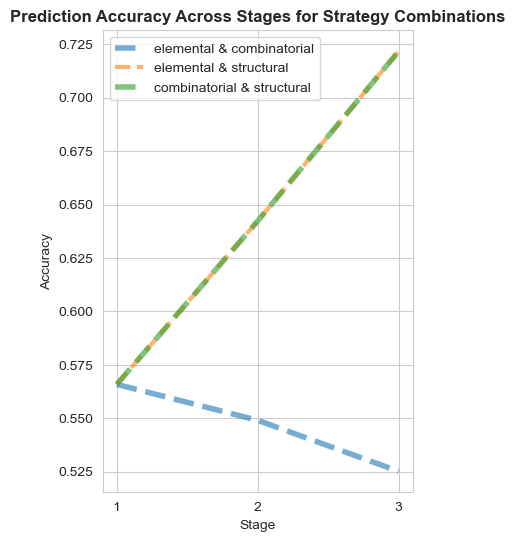

In [31]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def run_logistic_regression_for_strategy_custom(X, y):
    # Define the parameter grid for GridSearchCV
    param_grid = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}
    # Initialize and run GridSearchCV with logistic regression, focusing on accuracy as the performance metric
    gs = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='accuracy')
    gs.fit(X, y)
    # Best model from GridSearchCV
    best_model = gs.best_estimator_
    # Predict labels on the training set to compute accuracy
    y_pred = best_model.predict(X)
    test_accuracy = accuracy_score(y, y_pred)
    # Score the model using the default scoring method (accuracy), should be the same as test_accuracy
    score = best_model.score(X, y)
    # Extract coefficients
    coefficients = {feature: coef for feature, coef in zip(X.columns, best_model.coef_[0])}
    return coefficients, score, test_accuracy

# Prepare the figure for plotting all combinations
plt.figure(figsize=(4, 6))

# Define the strategy combinations
strategy_combinations = [
    ('elemental', 'combinatorial'),
    ('elemental', 'structural'),
    ('combinatorial', 'structural')
]

# Define line widths corresponding to each strategy combination for visibility
line_widths = {
    ('elemental', 'combinatorial'): 4,
    ('elemental', 'structural'): 3,
    ('combinatorial', 'structural'): 4
}

# Define predictors for each strategy
strategy_predictors = {
    'elemental': ['A', 'B', 'C'],
    'combinatorial': ['AandB', 'AandC', 'CandB'],
    'structural': ['AB', 'BA', 'AC', 'CA', 'BC', 'CB']
}

# Run logistic regression for each combination of strategies across stages
for strategies in strategy_combinations:
    auc_rocs = []  # to store AUC-ROC values for each stage
    stages = [1, 2, 3]  # Define the stages

    # Combine the predictors for the two strategies
    combined_predictors = strategy_predictors[strategies[0]] + strategy_predictors[strategies[1]]

    # Run logistic regression for each stage with the combined predictors
    for stage in stages:
        # Filter data for the current stage
        stage_data = combined_GLM_matrix[combined_GLM_matrix['stage'] == stage]
        X = stage_data[combined_predictors]
        y = stage_data['lick']

        # Perform logistic regression and get accuracy
        _, _, test_accuracy = run_logistic_regression_for_strategy_custom(X, y)
        auc_rocs.append(test_accuracy)

    # Plotting with specific line width
    plt.plot(stages, auc_rocs, '--', label=f'{strategies[0]} & {strategies[1]}', alpha=0.6, linewidth=line_widths[strategies])

# Finalize the plot
plt.title('Prediction Accuracy Across Stages for Strategy Combinations', fontweight='bold')
plt.xlabel('Stage')
plt.ylabel('Accuracy')
plt.xticks(stages)
plt.legend()
plt.grid(True)
plt.show()


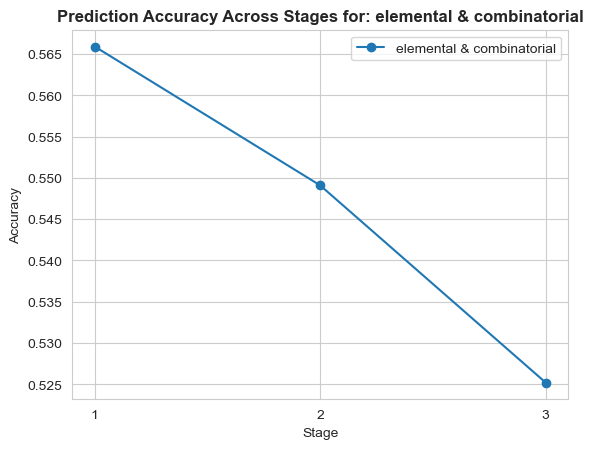

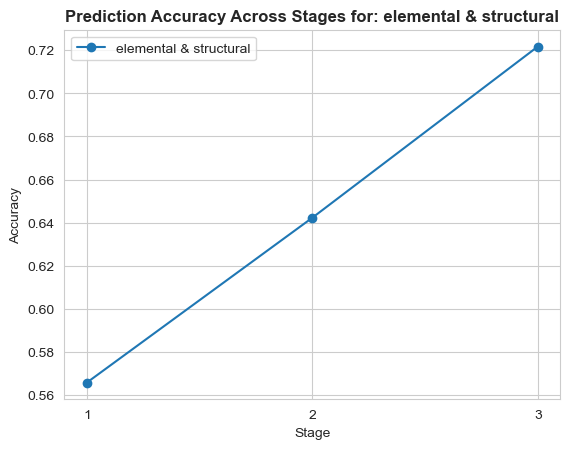

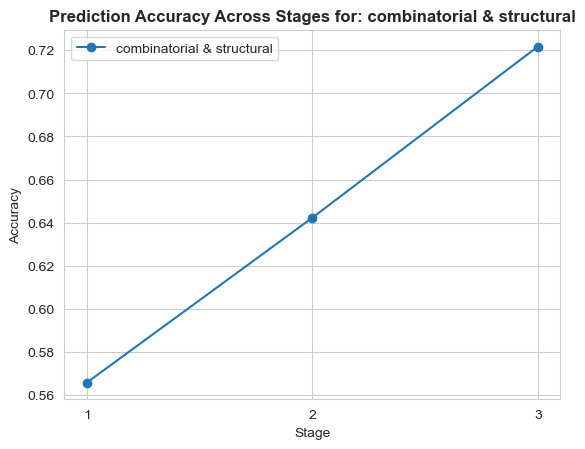

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def run_logistic_regression_for_strategy_custom(X, y):
    # Define the parameter grid for GridSearchCV
    param_grid = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}

    # Initialize and run GridSearchCV with logistic regression, focusing on accuracy as the performance metric
    gs = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='accuracy')
    gs.fit(X, y)

    # Best model from GridSearchCV
    best_model = gs.best_estimator_

    # Predict labels on the training set to compute accuracy
    y_pred = best_model.predict(X)
    test_accuracy = accuracy_score(y, y_pred)

    # Score the model using the default scoring method (accuracy), should be the same as test_accuracy
    score = best_model.score(X, y)

    # Extract coefficients - note: this approach assumes all predictors in X are linearly independent
    coefficients = {feature: coef for feature, coef in zip(X.columns, best_model.coef_[0])}

    return coefficients, score, test_accuracy


# Define the strategy combinations (two at a time)
strategy_combinations = [
    ('elemental', 'combinatorial'),
    ('elemental', 'structural'),
    ('combinatorial', 'structural')
]

# Define predictors for each strategy
strategy_predictors = {
    'elemental': ['A', 'B', 'C'],
    'combinatorial': ['AandB', 'AandC', 'CandB'],
    'structural': ['AB', 'BA', 'AC', 'CA', 'BC', 'CB']
}

# Run logistic regression for each combination of strategies across stages and plot the AUC-ROC values
for strategies in strategy_combinations:
    auc_rocs = []  # to store AUC-ROC values for each stage
    stages = [1, 2, 3]  # Define the stages

    # Combine the predictors for the two strategies
    combined_predictors = strategy_predictors[strategies[0]] + strategy_predictors[strategies[1]]

    # Run logistic regression for each stage with the combined predictors
    for stage in stages:
        # Filter data for the current stage
        stage_data = combined_GLM_matrix[combined_GLM_matrix['stage'] == stage]
        X = stage_data[combined_predictors]
        y = stage_data['lick']

        # Perform logistic regression and get AUC-ROC
        # Note: This assumes a modified 'run_logistic_regression_for_strategy' function that takes custom predictors
        _, _, test_auc_roc = run_logistic_regression_for_strategy_custom(X, y)  # Assume this function is similar but accepts X, y directly
        auc_rocs.append(test_auc_roc)

    # Plotting
    plt.plot(stages, auc_rocs, '-o', label=f'{strategies[0]} & {strategies[1]}')
    plt.title(f'Prediction Accuracy Across Stages for: {strategies[0]} & {strategies[1]}', fontweight ='bold')
    plt.xlabel('Stage')
    plt.ylabel('Accuracy')
    plt.xticks(stages)
    plt.legend()
    plt.grid(True)
    plt.show()


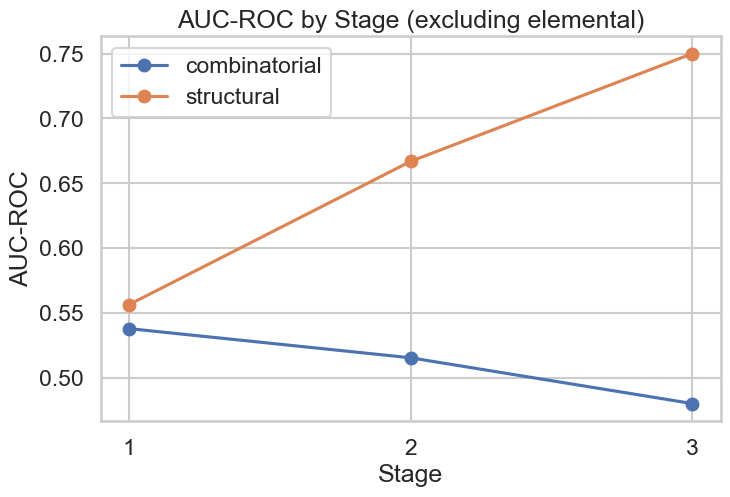

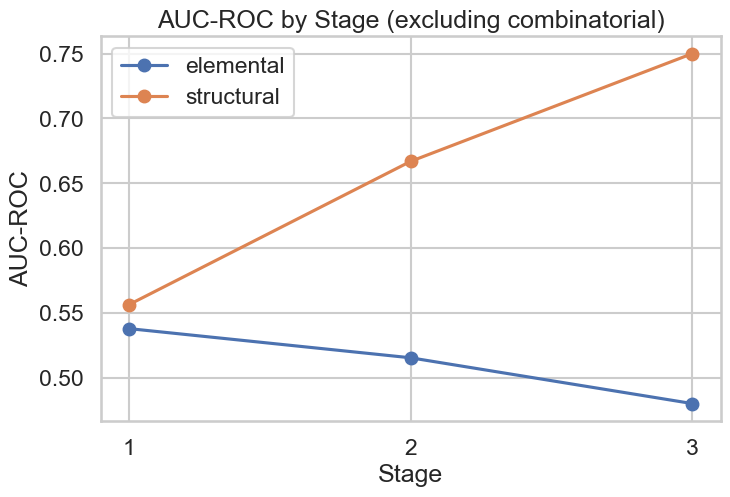

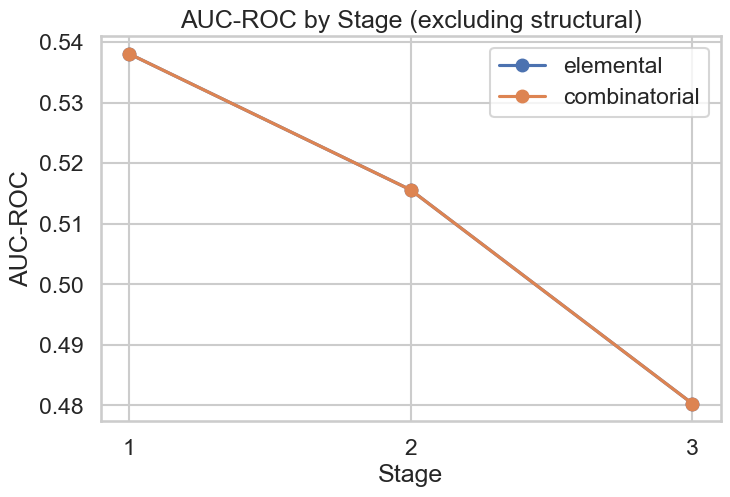

In [58]:
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame containing the results

# Define the strategies to loop through for leave-one-out analysis
strategies = ['elemental', 'combinatorial', 'structural']

# Loop through each strategy to leave out
for strategy_to_leave_out in strategies:
    # Filter the DataFrame to exclude the current strategy
    filtered_df = results_df[~results_df['Strategy'].isin([strategy_to_leave_out])]

    # Create a plot for the current set of strategies
    plt.figure(figsize=(8, 5))
    for strategy in filtered_df['Strategy'].unique():
        # Filter to current strategy
        strategy_data = filtered_df[filtered_df['Strategy'] == strategy]

        # Plot AUC-ROC for each stage
        plt.plot(strategy_data['Stage'], strategy_data['AUC-ROC'], '-o', label=strategy)

    plt.title(f'AUC-ROC by Stage (excluding {strategy_to_leave_out})')
    plt.xlabel('Stage')
    plt.ylabel('AUC-ROC')
    plt.xticks(filtered_df['Stage'].unique())  # Ensure x-ticks cover all stages
    plt.legend()
    plt.grid(True)
    plt.show()


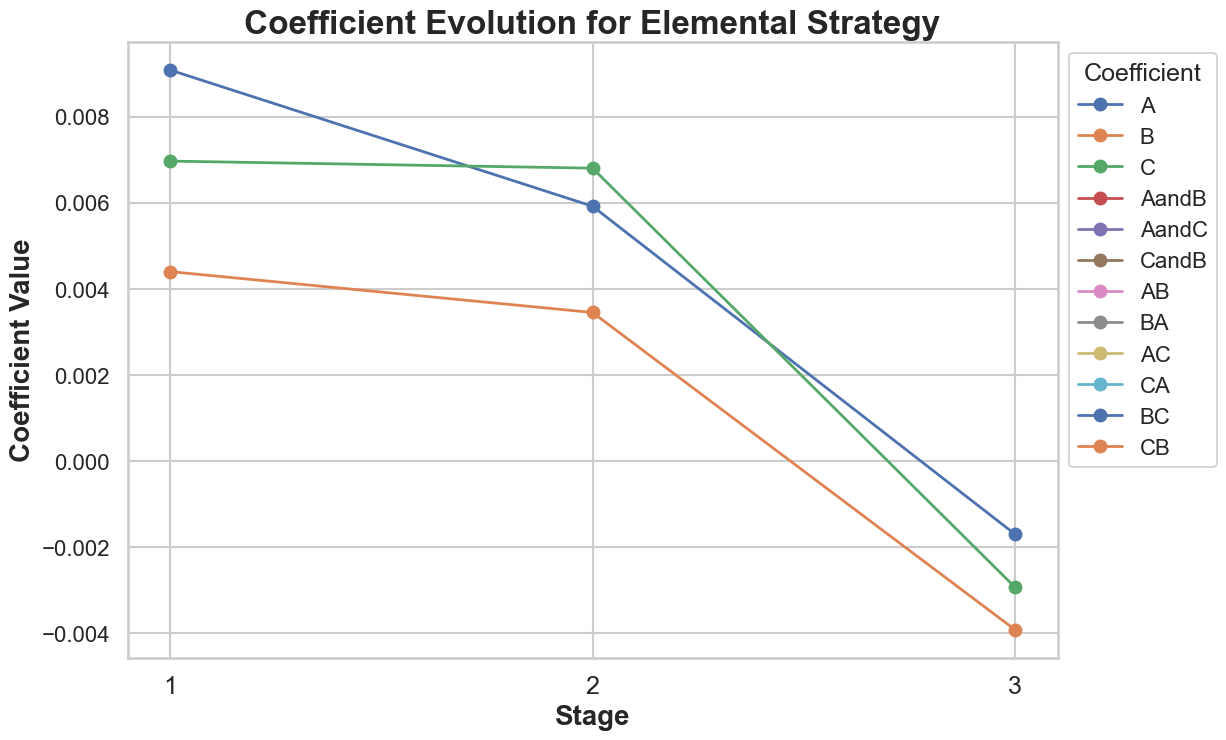

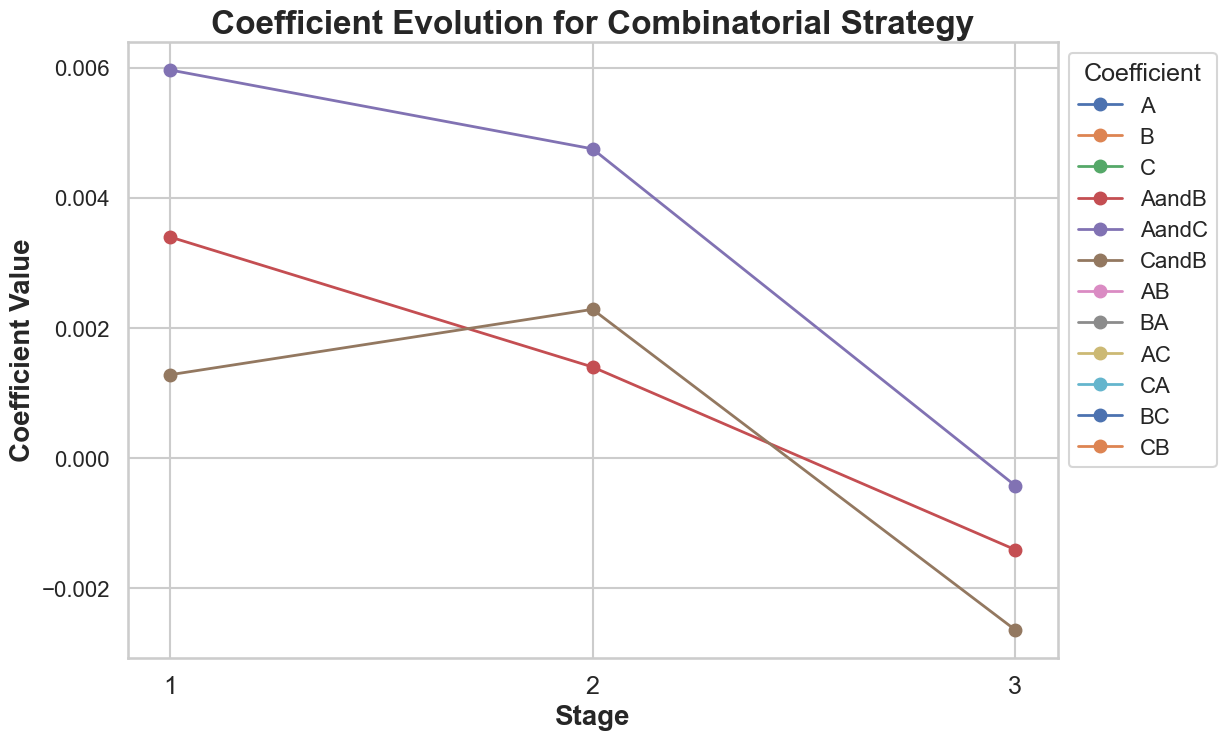

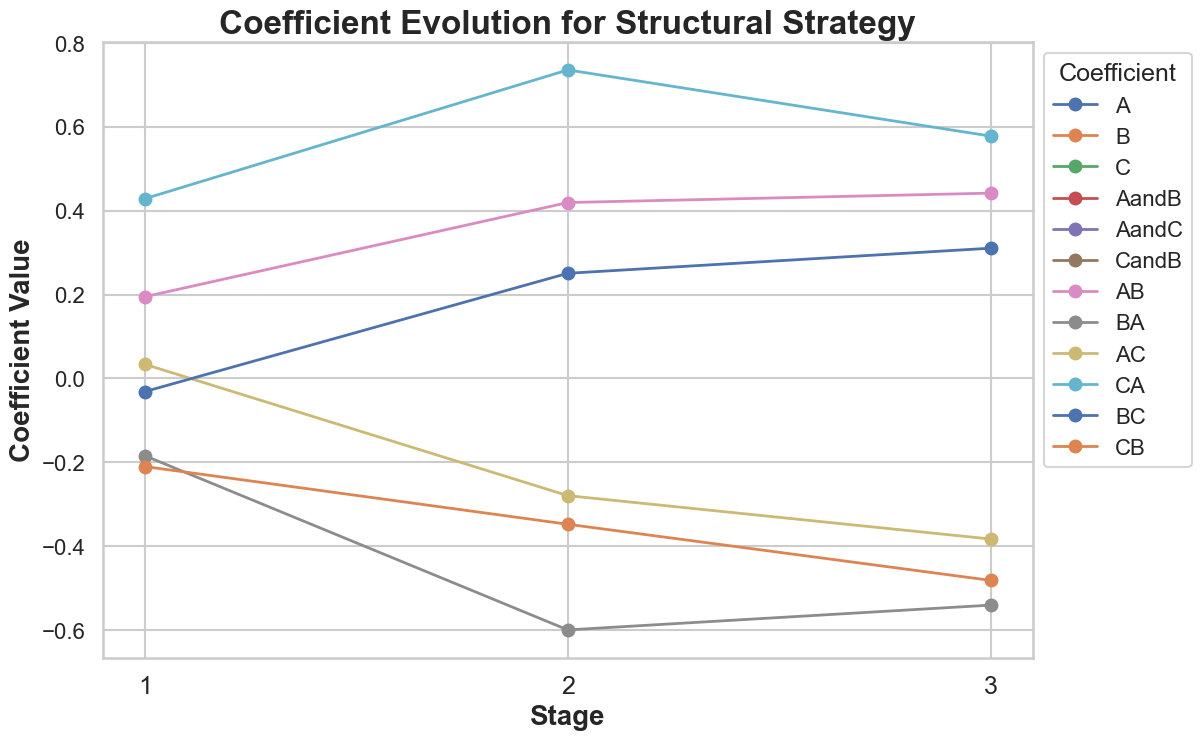

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the strategies and the potential columns that you'll plot
strategies = ['elemental', 'combinatorial', 'structural']
columns = ['A', 'B', 'C', 'AandB', 'AandC', 'CandB', 'AB', 'BA', 'AC', 'CA', 'BC', 'CB']

# Set the overall aesthetics for the plots
sns.set(style='whitegrid', context='talk')

for strategy in strategies:
    # Filter for the current strategy
    strategy_data = results_df[results_df['Strategy'] == strategy]

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))  # Increase the figure size for a poster

    # Initialize an empty list to store the labels for the legend
    legend_labels = []

    # Plot each coefficient that exists within the strategy
    for col in columns:
        if col in strategy_data.columns:
            plt.plot(strategy_data['Stage'], strategy_data[col], label=col, marker='o', linestyle='-', linewidth=2)
            legend_labels.append(col)  # Append the column to the legend labels if it's plotted

    # Set title and labels with increased font sizes for better readability
    plt.title(f'Coefficient Evolution for {strategy.capitalize()} Strategy', fontweight='bold', fontsize=24 )
    plt.xlabel('Stage', fontsize=20, fontweight='bold')
    plt.ylabel('Coefficient Value', fontsize=20, fontweight='bold')

    # Customize ticks for better readability
    plt.xticks(strategy_data['Stage'].unique(), fontsize=18)
    plt.yticks(fontsize=16)

    # Adjust the legend to only include labels for lines that were actually plotted
    plt.legend(legend_labels, title='Coefficient', title_fontsize='18', fontsize='16', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the grid
    plt.grid(True)

    # Display the plot
    plt.show()


# Now we will do drop one STRATEGY analysis

In [18]:
strategies = {
    'elemental': ['A', 'B', 'C'],
    'combinatorial': ['AandB', 'AandC', 'CandB'],
    'structural': ['AB', 'BA', 'AC', 'CA', 'BC', 'CB']
}

# Assuming combined_GLM_matrix is your DataFrame and it has a 'lick' column
# and all predictor columns are prefixed as in the strategies dictionary

def run_regression_excluding_strategy(data, excluded_strategy):
    # Combine the remaining strategies' predictors
    included_predictors = sum((v for k, v in strategies.items() if k != excluded_strategy), [])

    # Ensure only columns present in data are used
    included_predictors = [p for p in included_predictors if p in data.columns]

    # Extract the features and target variable
    X = data[included_predictors]
    y = data['lick']

    # Perform train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize and fit the logistic regression model
    model = LogisticRegression(solver='liblinear', max_iter=1000)  # You can adjust parameters as necessary
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Loop over the strategies and run the regression without each
results = {}
for strategy in strategies:
    accuracy = run_regression_excluding_strategy(combined_GLM_matrix, strategy)
    results[strategy] = accuracy
    print(f"Accuracy excluding {strategy} strategy: {accuracy:.4f}")

# Now `results` will contain the accuracy of the model excluding each strategy


Accuracy excluding elemental strategy: 0.6478
Accuracy excluding combinatorial strategy: 0.6478
Accuracy excluding structural strategy: 0.5271


In [19]:
def run_regression_excluding_strategy(data, stage_id, excluded_strategy):
    # Filter data for the current stage
    stage_data = data[data['stage'] == stage_id]

    # Define strategies and corresponding predictors
    strategies = {
        'elemental': ['A', 'B', 'C'],
        'combinatorial': ['AandB', 'AandC', 'CandB'],
        'structural': ['AB', 'BA', 'AC', 'CA', 'BC', 'CB']
    }

    # Combine the remaining strategies' predictors
    included_predictors = sum((v for k, v in strategies.items() if k != excluded_strategy), [])

    # Prepare predictors (X) and target variable (y)
    X = stage_data[included_predictors]
    y = stage_data['lick']

    # GridSearchCV to find the best model
    param_grid = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}
    gs = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='roc_auc')
    gs.fit(X, y)

    # Best model and its coefficients
    best_model = gs.best_estimator_
    coefficients = dict(zip(included_predictors, best_model.coef_[0]))

    return coefficients

# Loop over stages and exclude each strategy in turn
stages = [1, 2, 3]  # Adjust according to your study design if needed
strategies = ['elemental', 'combinatorial', 'structural']
results = {}

for stage in stages:
    results[stage] = {}
    for excluded_strategy in strategies:
        coefficients = run_regression_excluding_strategy(combined_GLM_matrix, stage, excluded_strategy)
        # Store the results
        results[stage][excluded_strategy] = coefficients

# Now `results` will contain the coefficients of the model for each stage, excluding one strategy at a time


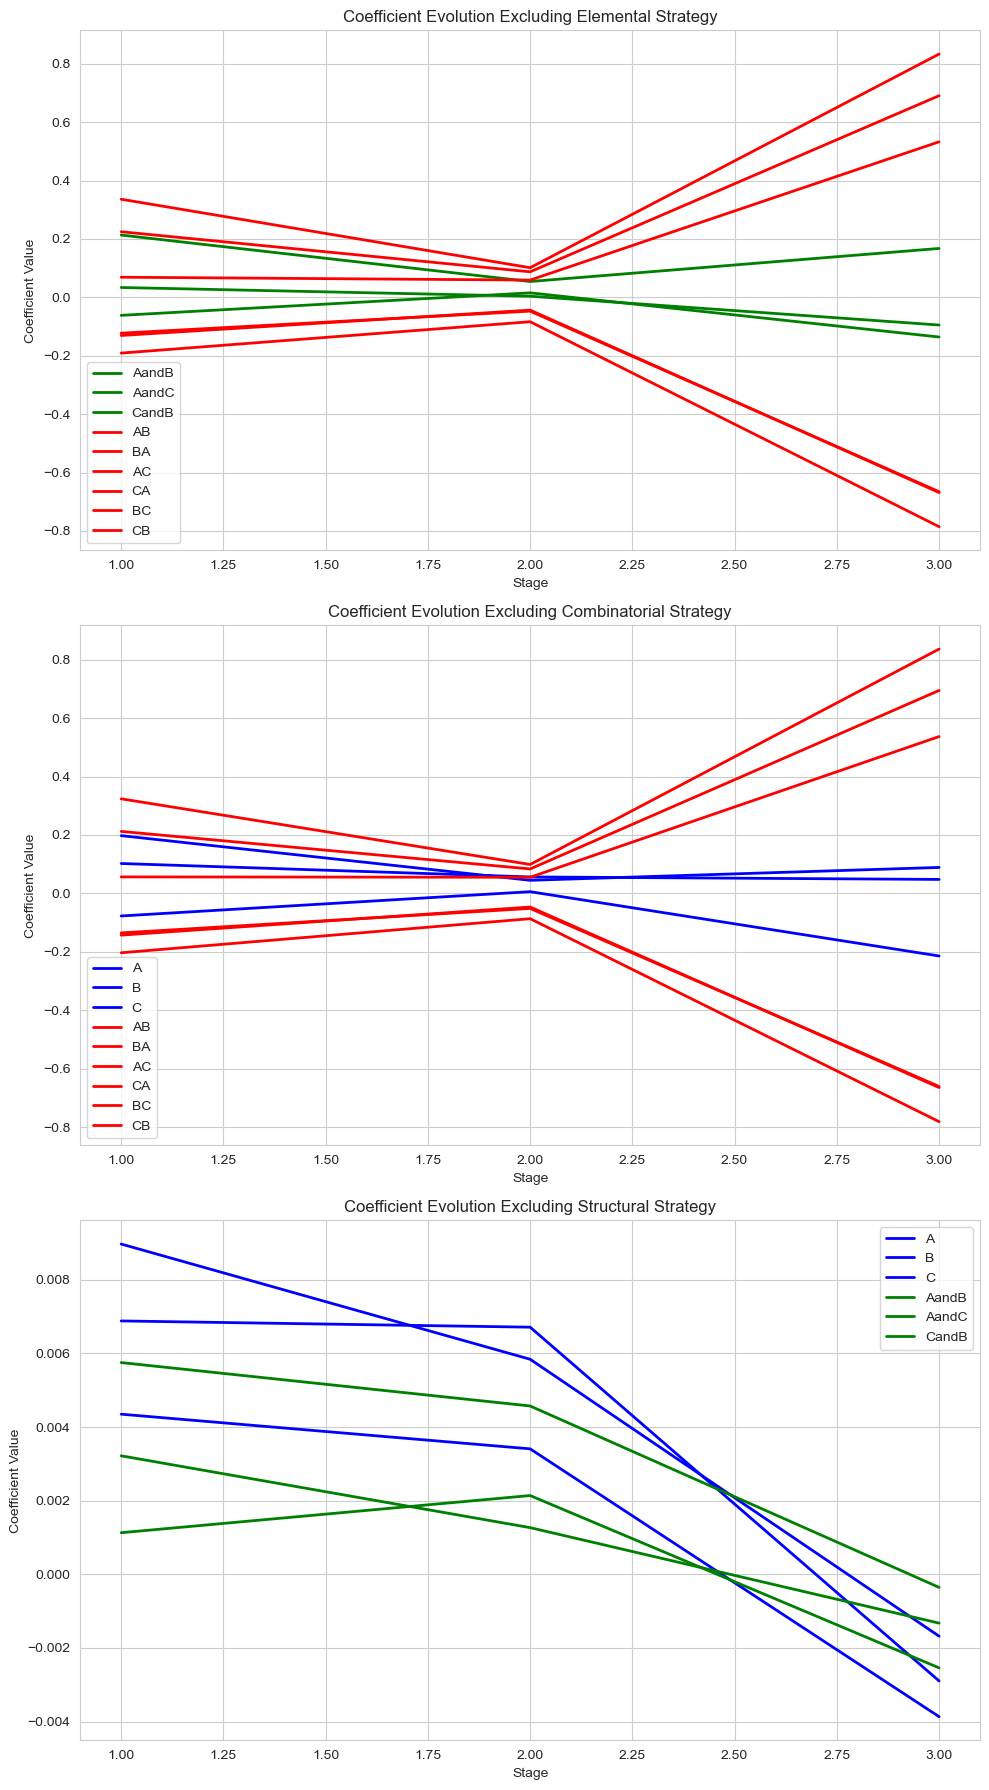

In [20]:
# Define colors for each strategy and map predictors to these colors
strategy_colors = {
    'elemental': 'blue',
    'combinatorial': 'green',
    'structural': 'red'
}

predictor_strategy_map = {
    'A': 'elemental', 'B': 'elemental', 'C': 'elemental',
    'AandB': 'combinatorial', 'AandC': 'combinatorial', 'CandB': 'combinatorial',
    'AB': 'structural', 'BA': 'structural', 'AC': 'structural', 'CA': 'structural',
    'BC': 'structural', 'CB': 'structural'
}

# Initialize figure with subplots for each strategy
fig, axs = plt.subplots(len(strategies), 1, figsize=(10, 18))

# Plot coefficients for each strategy excluding one
for i, strategy in enumerate(strategies):
    ax = axs[i]

    # Get coefficients for the current stage, excluding the current strategy
    predictors_data = {predictor: [] for predictor in predictor_strategy_map if predictor_strategy_map[predictor] != strategy}
    for stage_id in stages:
        coeffs = run_regression_excluding_strategy(combined_GLM_matrix, stage_id, strategy)
        for predictor, coeff_value in coeffs.items():
            predictors_data[predictor].append(coeff_value)

    # Plot each predictor with its strategy color, no markers
    for predictor, coeffs in predictors_data.items():
        ax.plot(stages, coeffs, linestyle='-', linewidth=2, color=strategy_colors[predictor_strategy_map[predictor]], label=predictor)

    # Set plot titles and labels
    ax.set_title(f'Coefficient Evolution Excluding {strategy.capitalize()} Strategy')
    ax.set_xlabel('Stage')
    ax.set_ylabel('Coefficient Value')
    ax.legend()
    ax.grid(True)

# Display the final plot layout
plt.tight_layout()
plt.show()

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_88617/3420916457.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(predictors, rotation=45, ha="right")


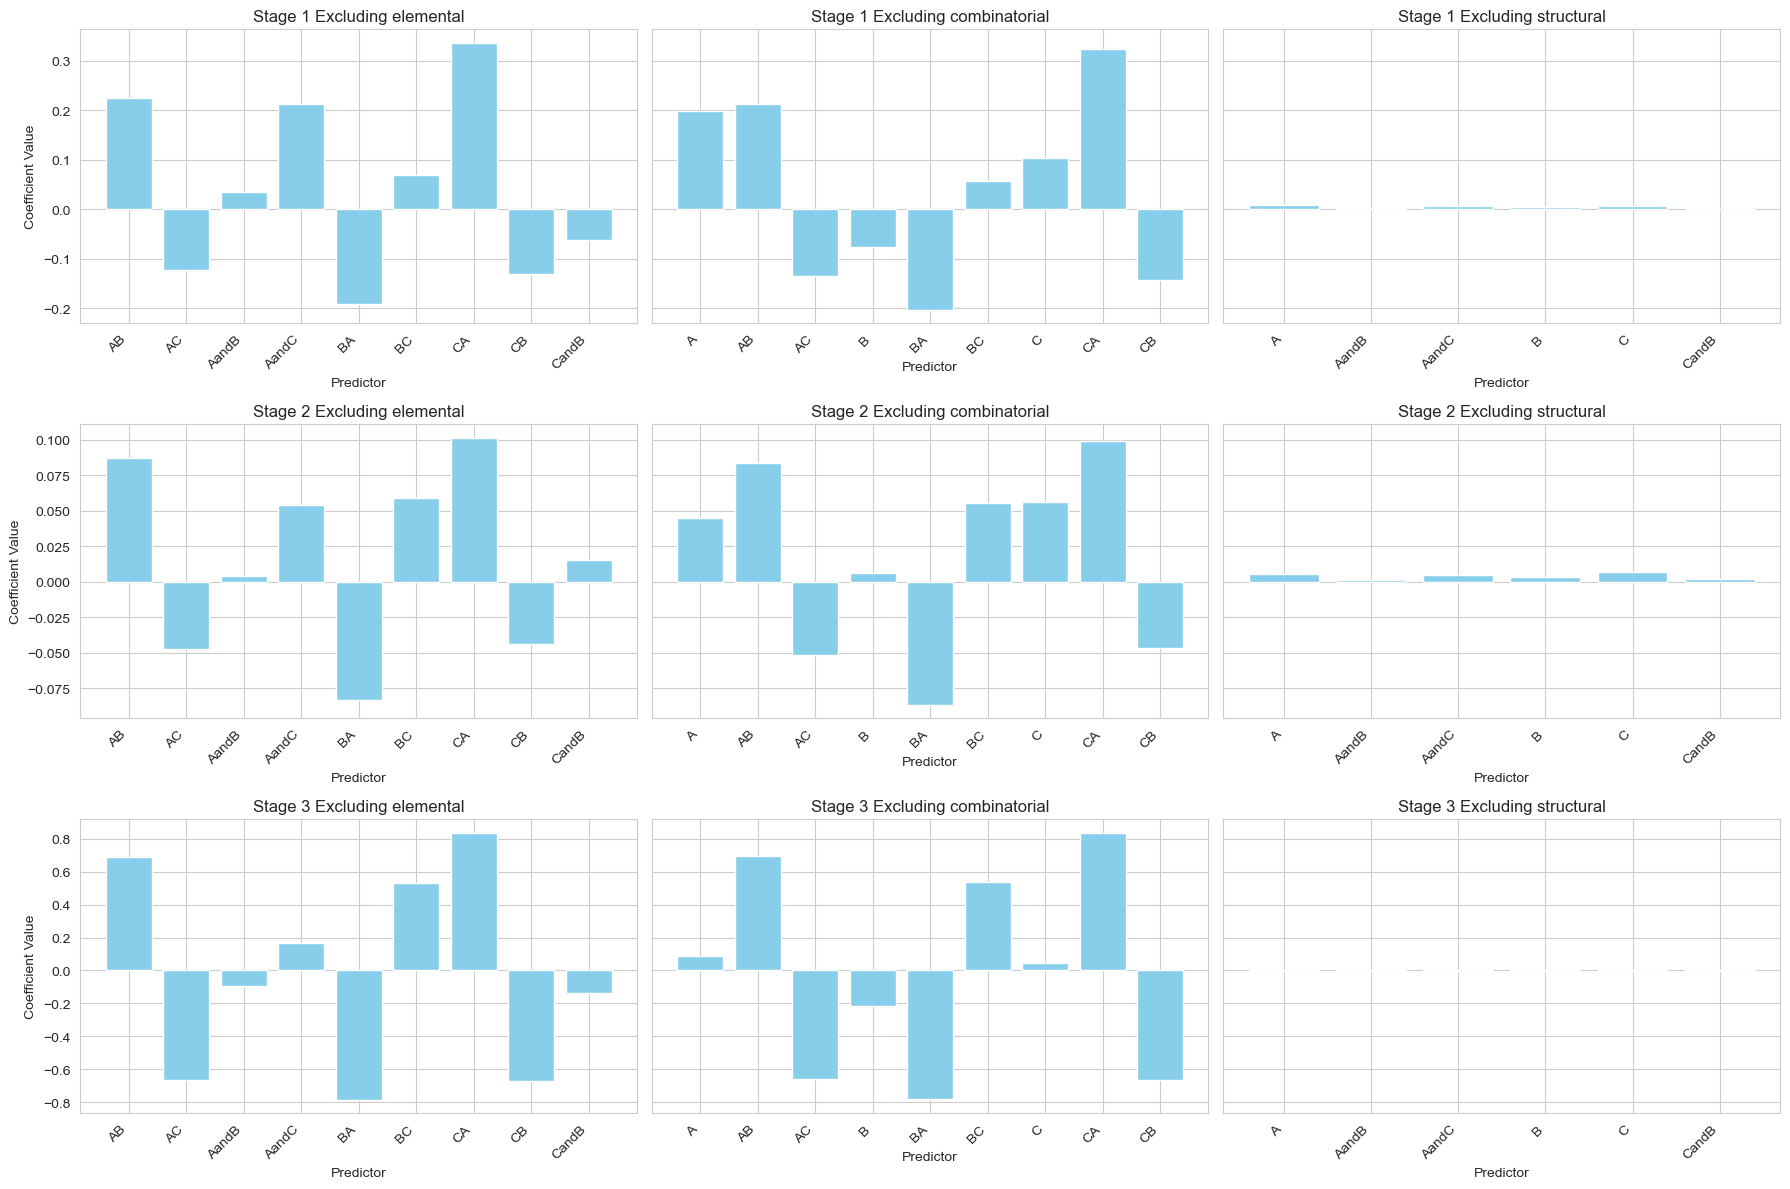

In [21]:
#A different way to visualize 

n_rows = len(stages)
n_cols = len(strategies)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), sharey='row')

# If there's only one row, axs may not be a 2D array, this ensures consistency
if n_rows == 1:
    axs = np.array([axs])

for row_idx, stage in enumerate(stages):
    for col_idx, excluded_strategy in enumerate(strategies):
        ax = axs[row_idx, col_idx]
        coefficients = results[stage][excluded_strategy]

        # Sorting predictors for consistent plotting
        predictors = sorted(coefficients.keys())
        weights = [coefficients[predictor] for predictor in predictors]

        ax.bar(predictors, weights, color='skyblue')

        ax.set_title(f'Stage {stage} Excluding {excluded_strategy}')
        ax.set_xticklabels(predictors, rotation=45, ha="right")
        ax.set_xlabel('Predictor')
        if col_idx == 0:
            ax.set_ylabel('Coefficient Value')

# Adjust layout to make room for the plot to be clear and readable
plt.tight_layout()
plt.show()


# Drop-one PREDICTOR analysis 

In [22]:
def calculate_unique_contribution(data, predictors, stage):
    results = {}

    # Filter data for the current stage
    stage_data = data[data['stage'] == stage]

    # Store the original log loss with all predictors
    model = LogisticRegression(max_iter=10000, solver='liblinear')
    model.fit(stage_data[predictors], stage_data['lick'])
    original_predictions = model.predict_proba(stage_data[predictors])
    original_log_loss = log_loss(stage_data['lick'], original_predictions)

    # Loop through each predictor
    for predictor in predictors:
        # Create a list of predictors excluding the current one
        reduced_predictors = [p for p in predictors if p != predictor]

        # Fit the model without the current predictor
        model.fit(stage_data[reduced_predictors], stage_data['lick'])
        reduced_predictions = model.predict_proba(stage_data[reduced_predictors])
        reduced_log_loss = log_loss(stage_data['lick'], reduced_predictions)

        # The change in log loss indicates the unique contribution of the removed predictor
        results[predictor] = original_log_loss - reduced_log_loss

    return results

# Assuming 'all_predictors' is a list of all predictors you used in your model
all_predictors = ['A', 'B', 'C', 'AandB', 'AandC', 'CandB', 'AB', 'BA', 'AC', 'CA', 'BC', 'CB']
stages = combined_GLM_matrix['stage'].unique()

# Dictionary to hold results for each stage
stage_unique_variance = {}

# Loop over each stage
for stage in stages:
    stage_unique_variance[stage] = calculate_unique_contribution(combined_GLM_matrix, all_predictors, stage)

# Output the results
for stage, results in stage_unique_variance.items():
    print(f"Stage {stage} unique variance contributions:")
    print(results)


Stage 1 unique variance contributions:
{'A': -9.460423300300391e-08, 'B': -2.140859045596244e-08, 'C': -4.323380486948025e-08, 'AandB': 4.494471905758246e-09, 'AandC': -8.533788287135025e-08, 'CandB': -8.077960078622937e-09, 'AB': -1.4735012985322982e-06, 'BA': -1.4620370942797223e-06, 'AC': -1.3540258896327373e-06, 'CA': -3.3063123938692485e-06, 'BC': -2.2846930169961865e-07, 'CB': -4.822753291167103e-07}
Stage 2 unique variance contributions:
{'A': -2.2811797406596668e-07, 'B': -2.213294091335527e-07, 'C': -3.060250103326112e-07, 'AandB': -3.679485738317112e-08, 'AandC': -5.007654897415392e-07, 'CandB': -2.694537259984031e-09, 'AB': -1.4155689296191376e-05, 'BA': -1.748242832022573e-05, 'AC': -2.1403345640269578e-05, 'CA': -3.591435369332263e-05, 'BC': -4.261141004713309e-06, 'CB': -5.590900446827973e-06}
Stage 3 unique variance contributions:
{'A': -2.038615845023628e-07, 'B': -1.0505756313783365e-06, 'C': -1.3268769849528184e-07, 'AandB': -1.6369784971992374e-07, 'AandC': -7.892215

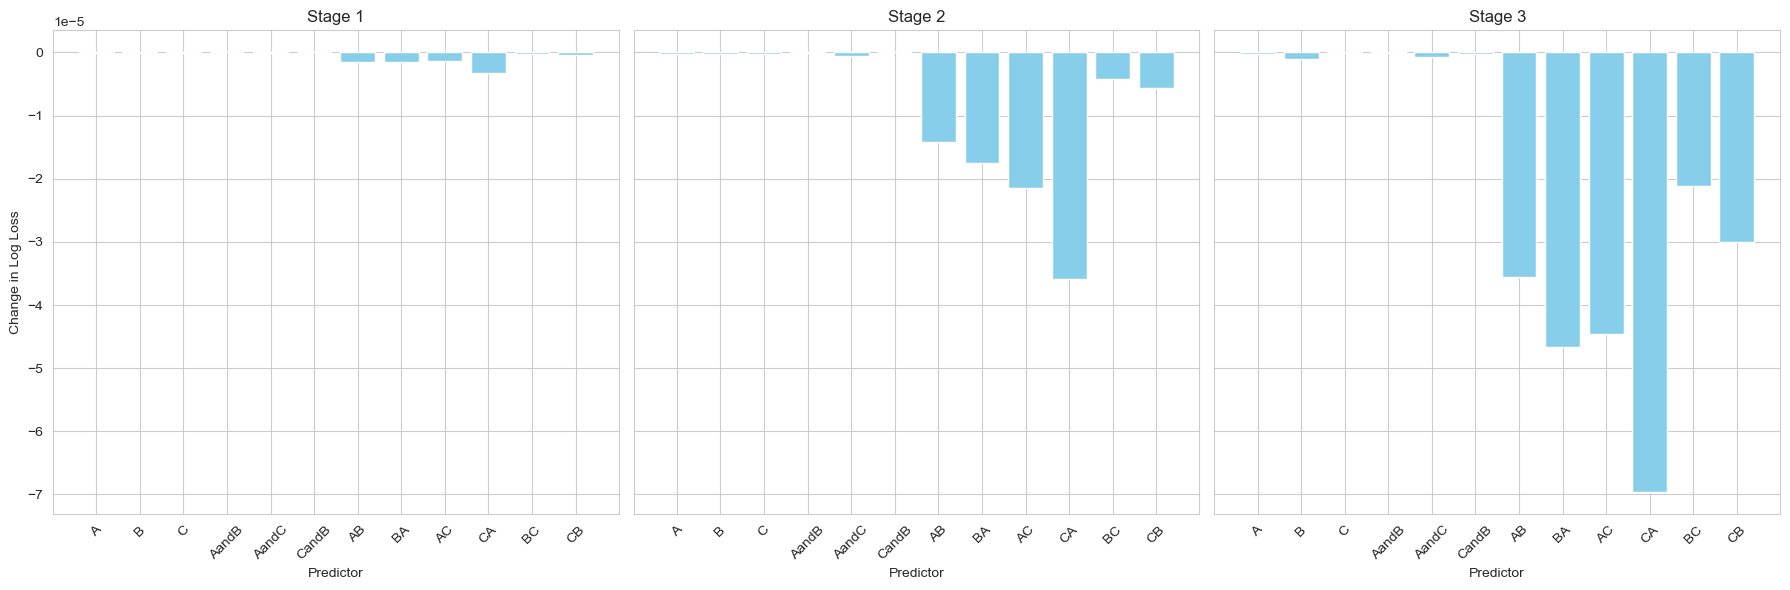

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Assuming 'stage_unique_variance' is a dictionary containing your results
stages = sorted(stage_unique_variance.keys())
for i, stage in enumerate(stages):
    contributions = stage_unique_variance[stage]
    predictors = list(contributions.keys())
    values = list(contributions.values())

    axes[i].bar(predictors, values, color='skyblue')

    # Adding the title and labels
    axes[i].set_title(f'Stage {stage}')
    axes[i].set_xlabel('Predictor')
    if i == 0:  # Only add y label to the first subplot for clarity
        axes[i].set_ylabel('Change in Log Loss')
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout so labels don't overlap
plt.tight_layout()

# Show the plot
plt.show()
